In [62]:
import numpy as np
from scipy import special as sp
from matplotlib import pyplot as plt
%matplotlib inline

In [63]:
test_data = np.genfromtxt('demo-data.csv', 
                          delimiter=',',
                          dtype='int',
                          names=True)

In [64]:
#np.random.binomial(100, .15, 100)
#np.random.beta(10, 50, 100)
#test_success = np.random.binomial(100, .15, 100)
#test_success

In [65]:
def add_ones(a_control, B_control, a_test, B_test):
    """Adds one to all input parameters"""
    a_control += 1
    B_control += 1
    a_test += 1
    B_test += 1
    return a_control, B_control, a_test, B_test

In [66]:
#source: http://www.evanmiller.org/bayesian-ab-testing.html
def probability_test_wins(a_control, B_control, a_test, B_test):
    """Uses beta distribution to compute the % chance that _test has a better conversion 
    rate than _control"""
    a_control, B_control, a_test, B_test = add_ones(a_control, B_control, a_test, B_test)
    total = 0.0
    for i in range(0, a_test - 1):
        total += np.exp(
                          sp.betaln(a_control + i, B_control + B_test) 
                        - np.log(B_test + i)
                        - sp.betaln(1 + i, B_test) 
                        - sp.betaln(a_control, B_control)
                       )
    return total

In [67]:
def run_analysis(test_data):
    test_success_cum, test_failure_cum, control_success_cum, control_failure_cum = 0, 0, 0, 0
    # test the probability test beats control on cumulative counts for each observation.
    # This represents all the possible test information current as of the date in question.
    N = test_data.shape[0]
    results = [{'obs': i, 'p':0.00, 'test_cumulative': 0.00, 'control_cumulative': 0.00} 
               for i in range(N)]
    for i in range(len(results)):
        test_success = test_data['test_success'][i]
        test_failure = test_data['test_total'][i] - test_success
        control_success = test_data['control_success'][i]
        control_failure = test_data['control_total'][i] - control_success
        
        test_success_cum += test_success
        test_failure_cum += test_failure
        control_success_cum += control_success
        control_failure_cum += control_failure
        
        
        test_cumulative = test_success_cum / (test_success_cum + test_failure_cum)
        control_cumulative = control_success_cum / (control_success_cum + control_failure_cum)
        p_win = probability_test_wins(a_control=control_success_cum, 
                                       B_control=control_failure_cum,
                                       a_test=test_success_cum, 
                                       B_test=test_failure_cum)
        
        #
        results[i]['p'] = p_win
        results[i]['test_cumulative'] = test_cumulative
        results[i]['control_cumulative'] = control_cumulative
    return results

In [68]:
results = run_analysis(test_data)

In [69]:
# look at cumulative stats from last observation to get current difference:
results[-1]

{'obs': 140,
 'p': 1.0000000000152893,
 'test_cumulative': 0.15981683532138619,
 'control_cumulative': 0.11568583575744014}

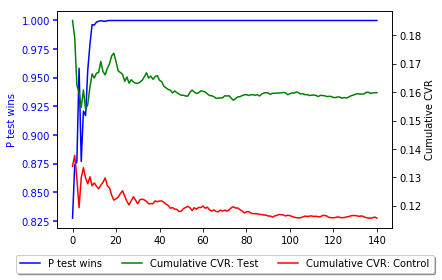

In [70]:
def plot_test_results(p_name, test_group_name, control_group_name)

# setup
fig, host = plt.subplots()
par1 = host.twinx()

# extract plotting data
index = range(0, len(results))
ps = [r['p'] for r in results]
test_cvr = [r['test_cumulative'] for r in results]
cont_cvr = [r['control_cumulative'] for r in results]

# labels
p_label = "P test wins"
test_cvr_label = "Cumulative CVR: Test"
contol_cvr_label = "Cumulative CVR: Control"

# make plots
p1, = host.plot(index, ps, "b-", label=p_label)
p2, = par1.plot(index, test_cvr, "g-", label=test_cvr_label)
p3, = par1.plot(index, cont_cvr, "r-", label=contol_cvr_label)

# set labels
tkw = dict(size=4, width=1.5)
host.set_ylabel(p_label)
host.yaxis.label.set_color(p1.get_color())
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.set_ylabel("Cumulative CVR")

# add legend
lines = [p1, p2, p3]
host.legend(lines, 
            [l.get_label() for l in lines], 
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.1),
            fancybox=True, 
            shadow=True, 
            ncol=3)
plt.show()